# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda)

In [2]:
# Import packages
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")

In [3]:
display(drug_safety)
display(drug_safety.info())

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0
...,...,...,...,...,...,...,...,...
16098,78,male,Placebo,16,NaN,NaN,Yes,1
16099,78,male,Placebo,2,7.5,4.9,No,0
16100,78,male,Placebo,20,NaN,NaN,Yes,1
16101,78,male,Placebo,4,6.4,4.8,No,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              16103 non-null  int64  
 1   sex              16103 non-null  object 
 2   trx              16103 non-null  object 
 3   week             16103 non-null  int64  
 4   wbc              9128 non-null   float64
 5   rbc              9127 non-null   float64
 6   adverse_effects  16103 non-null  object 
 7   num_effects      16103 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1006.6+ KB


None

# The distribution of adverse effects

Text(0.5, 1.0, 'Distribution of the Number of Adverse Effects between the Groups')

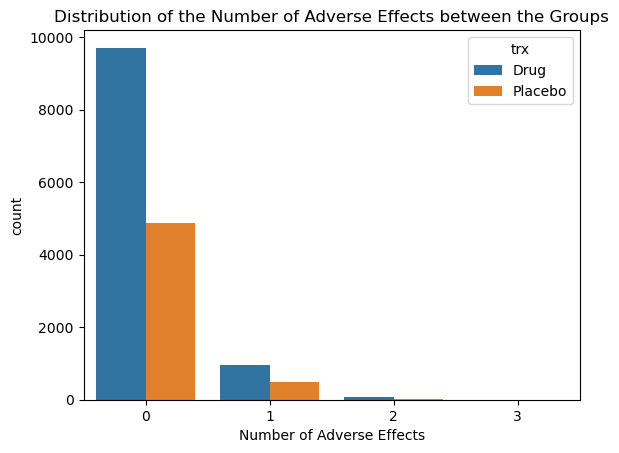

In [4]:
plot_num_eff = sns.countplot(data=drug_safety,x='num_effects',hue='trx')
plt.xlabel("Number of Adverse Effects")
plt.title("Distribution of the Number of Adverse Effects between the Groups")

# Two samples proportions z test

In [11]:
trx_by_adverse_effects = drug_safety.groupby('trx')['adverse_effects'].value_counts()

yeses = [trx_by_adverse_effects[('Drug','Yes')], trx_by_adverse_effects[('Placebo','Yes')]]

nobs = drug_safety.groupby('trx')['adverse_effects'].count()

two_samp_z_stat, two_samp_z_p_value = proportions_ztest(yeses,nobs,alternative='two-sided')
two_samp_z_stat = round(two_samp_z_stat,3)
two_samp_z_p_value = round(two_samp_z_p_value,3)
print('z-stat:',two_samp_z_stat,'\np-value:', two_samp_z_p_value)

trx
Drug       10727
Placebo     5376
Name: num_effects, dtype: int64

z-stat: 0.045 
p-value: 0.964


 there is insufficient evidence to conclude that the treatment has a significant impact on the occurrence of adverse effects (adverse_effects). The observed difference is likely attributed to random variability in the data.

# Association between adverse effects and the groups

In [6]:
expected, observed, stats = pingouin.chi2_independence(data=drug_safety,
                                                       x='num_effects',y='trx')
pearson_num_effect_trx = stats[stats['test'] == 'pearson'].round(3)
print(pearson_num_effect_trx)

      test  lambda  chi2  dof   pval  cramer  power
0  pearson     1.0   1.8  3.0  0.615   0.011  0.176


/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/pingouin/contingency.py:150: UserWarning: Low count on observed frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/pingouin/contingency.py:150: UserWarning: Low count on expected frequencies.
  warnings.warn("Low count on {} frequencies.".format(name))
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/scipy/_lib/_util.py:69: RuntimeWarning: overflow encountered in _ncx2_sf
  np.place(out, cond, f(*temp))


 there is no significant evidence to suggest an association between the number of adverse effects (num_effects) and the treatment group (trx). The variables appear to be independent of each other.

# Distribution of age in the Drug and Placebo groups

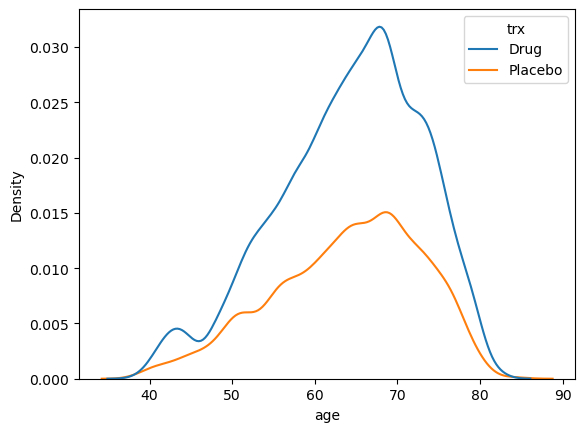

In [7]:
plot_age = sns.kdeplot(data=drug_safety,x='age',hue='trx')

# Significant difference between the ages of both groups

In [8]:
drugs = drug_safety.loc[drug_safety['trx']=='Drug','age']
placebo = drug_safety.loc[drug_safety['trx']=='Placebo','age']
two_ind_ttest_results = pingouin.ttest(drugs,placebo,paired=False).round(3)
display(two_ind_ttest_results)
two_ind_samp_results = pingouin.mwu(drugs,placebo).round(3)
display(two_ind_samp_results)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.475,10580.407,two-sided,0.14,"[-0.07, 0.51]",0.025,0.056,0.317


,U-val,alternative,p-val,RBC,CLES
MWU,29149339.5,two-sided,0.257,-0.011,0.505


there is no significant evidence to suggest a difference in age between the treatment and control groups. 